# Making the Most of your Colab Subscription



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

BASE_DIR = "/content/drive/MyDrive/IEEE Data"

TRAIN_TXN_PATH = os.path.join(BASE_DIR, "train_transaction.csv")
TRAIN_ID_PATH  = os.path.join(BASE_DIR, "train_identity.csv")

TEST_TXN_PATH = os.path.join(BASE_DIR, "test_transaction.csv")
TEST_ID_PATH  = os.path.join(BASE_DIR, "test_identity.csv")

In [3]:
import pandas as pd

train_transaction = pd.read_csv(TRAIN_TXN_PATH)
train_identity = pd.read_csv(TRAIN_ID_PATH)

print("Train transaction shape:", train_transaction.shape)
print("Train identity shape:", train_identity.shape)

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)


In [4]:
import pandas as pd

train = train_transaction.merge(
    train_identity,
    on="TransactionID",
    how="left"
)

print("Merged shape:", train.shape)

Merged shape: (590540, 434)


In [5]:
TARGET = "isFraud"
DROP_COLS = ["TransactionID", TARGET]

y = train[TARGET]
train = train.drop(columns=DROP_COLS)

print("Remaining columns:", train.shape[1])

Remaining columns: 432


In [6]:
categorical_cols = []
numerical_cols = []

for col in train.columns:
    if train[col].dtype == "object":
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

print("Categorical columns:", len(categorical_cols))
print("Numerical columns:", len(numerical_cols))

Categorical columns: 31
Numerical columns: 401


In [7]:
train["card_entity"] = train["card1"].astype(str)
categorical_cols.append("card_entity")

In [8]:
train["addr_entity"] = train["addr1"].astype(str)
categorical_cols.append("addr_entity")

In [9]:
train["email_entity"] = train["P_emaildomain"].fillna("missing")
categorical_cols.append("email_entity")

In [10]:
train["uid"] = (
    train["card1"].astype(str) + "_" +
    train["addr1"].astype(str)
)
categorical_cols.append("uid")


In [11]:
SECONDS_IN_DAY = 24 * 60 * 60

train["DT_day"] = train["TransactionDT"] // SECONDS_IN_DAY
train["DT_hour"] = (train["TransactionDT"] // 3600) % 24

numerical_cols.extend(["DT_day", "DT_hour"])

In [12]:
import numpy as np

train["TransactionAmt_log"] = np.log1p(train["TransactionAmt"])
numerical_cols.append("TransactionAmt_log")

In [13]:
categorical_cols = list(set(categorical_cols))
numerical_cols = list(set(numerical_cols))

# Safety checks
assert TARGET not in categorical_cols
assert TARGET not in numerical_cols

print("Final categorical:", len(categorical_cols))
print("Final numerical:", len(numerical_cols))

Final categorical: 35
Final numerical: 404


In [14]:
train = train.sort_values("TransactionDT").reset_index(drop=True)
y = y.loc[train.index].reset_index(drop=True)


In [15]:
split_day = train["DT_day"].quantile(0.80)

train_idx = train["DT_day"] <= split_day
val_idx   = train["DT_day"] > split_day

X_train = train.loc[train_idx]
X_val   = train.loc[val_idx]

y_train = y.loc[train_idx]
y_val   = y.loc[val_idx]

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Fraud rate (train):", y_train.mean())
print("Fraud rate (val):", y_val.mean())

Train size: (475006, 439)
Validation size: (115534, 439)
Fraud rate (train): 0.035201660610602814
Fraud rate (val): 0.03411982619834854


In [16]:
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_val[col]   = X_val[col].astype("category")

/tmp/ipython-input-3858091861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype("category")
/tmp/ipython-input-3858091861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col]   = X_val[col].astype("category")
/tmp/ipython-input-3858091861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [17]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

print("Scale pos weight:", scale_pos_weight)


Scale pos weight: 27.407750732611685


In [18]:
import lightgbm as lgb

lgb_train = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_cols,
    free_raw_data=False
)

lgb_val = lgb.Dataset(
    X_val,
    label=y_val,
    categorical_feature=categorical_cols,
    reference=lgb_train,
    free_raw_data=False
)

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "min_data_in_leaf": 200,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "scale_pos_weight": scale_pos_weight,
    "seed": 42,
    "verbosity": -1
}

model_baseline = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50)
    ]
)


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.982627	valid_1's auc: 0.891281
[100]	training's auc: 0.990197	valid_1's auc: 0.894016
[150]	training's auc: 0.993704	valid_1's auc: 0.894168
[200]	training's auc: 0.995814	valid_1's auc: 0.893333
Early stopping, best iteration is:
[126]	training's auc: 0.99232	valid_1's auc: 0.894839


In [19]:
val_preds = model_baseline.predict(X_val)

In [20]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_val, val_preds)
pr_auc = auc(recall, precision)

print("Baseline PR-AUC:", pr_auc)


Baseline PR-AUC: 0.538637472505122


In [21]:
import numpy as np

baseline_thresh = 0.5
y_pred_base = (val_preds >= baseline_thresh).astype(int)

FP_base = ((y_pred_base == 1) & (y_val == 0)).sum()
TP_base = ((y_pred_base == 1) & (y_val == 1)).sum()
FN_base = ((y_pred_base == 0) & (y_val == 1)).sum()

recall_base = TP_base / (TP_base + FN_base)

print("Baseline recall:", recall_base)
print("Baseline false positives:", FP_base)


Baseline recall: 0.6435819381024861
Baseline false positives: 5590


In [22]:
# Ensure sorted by time (CRITICAL)
train = train.sort_values("TransactionDT").reset_index(drop=True)
y = y.loc[train.index].reset_index(drop=True)

# Time since last transaction per UID
train["uid_prev_time"] = train.groupby("uid")["TransactionDT"].shift(1)
train["uid_time_since_last"] = train["TransactionDT"] - train["uid_prev_time"]
train["uid_time_since_last"] = train["uid_time_since_last"].fillna(999999)

numerical_cols.append("uid_time_since_last")


In [23]:
# Cumulative count of transactions per UID (past only)
train["uid_txn_count"] = train.groupby("uid").cumcount()

# Same for card
train["card_txn_count"] = train.groupby("card_entity").cumcount()

numerical_cols.extend(["uid_txn_count", "card_txn_count"])


In [24]:
# Historical mean amount per UID (past only)
train["uid_amt_cum_sum"] = train.groupby("uid")["TransactionAmt"].cumsum() - train["TransactionAmt"]
train["uid_amt_cum_cnt"] = train["uid_txn_count"].replace(0, 1)

train["uid_amt_mean"] = train["uid_amt_cum_sum"] / train["uid_amt_cum_cnt"]
train["uid_amt_ratio"] = train["TransactionAmt"] / (train["uid_amt_mean"] + 1e-6)

numerical_cols.extend(["uid_amt_mean", "uid_amt_ratio"])


In [25]:
train["card_amt_cum_sum"] = train.groupby("card_entity")["TransactionAmt"].cumsum() - train["TransactionAmt"]
train["card_amt_cum_cnt"] = train["card_txn_count"].replace(0, 1)

train["card_amt_mean"] = train["card_amt_cum_sum"] / train["card_amt_cum_cnt"]
train["card_amt_ratio"] = train["TransactionAmt"] / (train["card_amt_mean"] + 1e-6)

numerical_cols.extend(["card_amt_mean", "card_amt_ratio"])


In [26]:
train["email_seen_before"] = (
    train.groupby(["card_entity", "email_entity"]).cumcount() > 0
).astype(int)

numerical_cols.append("email_seen_before")


In [27]:
DROP_HELPERS = [
    "uid_prev_time",
    "uid_amt_cum_sum", "uid_amt_cum_cnt",
    "card_amt_cum_sum", "card_amt_cum_cnt"
]

train = train.drop(columns=DROP_HELPERS)


In [28]:
train[[
    "uid_txn_count",
    "uid_time_since_last",
    "uid_amt_ratio",
    "card_amt_ratio",
    "email_seen_before"
]].describe()


,uid_txn_count,uid_time_since_last,uid_amt_ratio,card_amt_ratio,email_seen_before
count,590540.000000,5.905400e+05,5.905400e+05,5.905400e+05,590540.000000
mean,392.056809,4.123807e+05,1.048246e+07,3.316789e+06,0.926371
std,991.791750,1.053052e+06,7.751510e+07,4.249042e+07,0.261167
min,0.000000,0.000000e+00,3.985580e-03,2.895848e-03,0.000000
25%,8.000000,3.709000e+03,4.313290e-01,3.970145e-01,1.000000
50%,48.000000,5.088150e+04,7.722534e-01,6.747179e-01,1.000000
75%,277.000000,3.486868e+05,1.441094e+00,1.222183e+00,1.000000
max,9927.000000,1.559967e+07,5.279950e+09,4.517710e+09,1.000000


In [29]:
split_day = train["DT_day"].quantile(0.80)

train_idx = train["DT_day"] <= split_day
val_idx   = train["DT_day"] > split_day

X_train = train.loc[train_idx]
X_val   = train.loc[val_idx]

y_train = y.loc[train_idx]
y_val   = y.loc[val_idx]


In [30]:
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_val[col]   = X_val[col].astype("category")


/tmp/ipython-input-2762578398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype("category")
/tmp/ipython-input-2762578398.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col]   = X_val[col].astype("category")
/tmp/ipython-input-2762578398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [31]:
lgb_train = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=categorical_cols,
    free_raw_data=False
)

lgb_val = lgb.Dataset(
    X_val, label=y_val,
    categorical_feature=categorical_cols,
    reference=lgb_train,
    free_raw_data=False
)

model_behavioral = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(100),
        lgb.log_evaluation(50)
    ]
)


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.987652	valid_1's auc: 0.900892
[100]	training's auc: 0.993628	valid_1's auc: 0.903864
[150]	training's auc: 0.996303	valid_1's auc: 0.903238
[200]	training's auc: 0.997731	valid_1's auc: 0.902031
Early stopping, best iteration is:
[118]	training's auc: 0.994801	valid_1's auc: 0.904275


In [32]:
val_preds_new = model_behavioral.predict(X_val)

precision, recall, _ = precision_recall_curve(y_val, val_preds_new)
pr_auc_new = auc(recall, precision)

print("Baseline PR-AUC:", pr_auc)
print("Behavioral PR-AUC:", pr_auc_new)


Baseline PR-AUC: 0.538637472505122
Behavioral PR-AUC: 0.5609806544503395


In [33]:
target_recall = 0.96

# Baseline
prec_b, rec_b, thr_b = precision_recall_curve(y_val, val_preds)
idx_b = (rec_b >= target_recall).nonzero()[0][-1]
thr_base = thr_b[idx_b]

FP_base = ((val_preds >= thr_base) & (y_val == 0)).sum()

# New model
prec_n, rec_n, thr_n = precision_recall_curve(y_val, val_preds_new)
idx_n = (rec_n >= target_recall).nonzero()[0][-1]
thr_new = thr_n[idx_n]

FP_new = ((val_preds_new >= thr_new) & (y_val == 0)).sum()

fp_reduction = 100 * (FP_base - FP_new) / FP_base

print(f"False positive reduction: {fp_reduction:.2f}% at {target_recall*100:.0f}% recall")


False positive reduction: 9.29% at 96% recall


In [34]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def threshold_for_target_recall(y_true, y_prob, target_recall=0.96):
    """
    Returns the highest threshold that still achieves recall >= target_recall.
    Higher threshold => fewer false positives.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # precision_recall_curve returns thresholds length = len(precision)-1
    # recall/precision have one extra element
    recall_for_thresh = recall[:-1]

    valid = np.where(recall_for_thresh >= target_recall)[0]
    if len(valid) == 0:
        # Can't reach target recall; fallback to lowest threshold
        return thresholds[0]

    # choose the highest threshold among those that meet recall target
    return thresholds[valid].max()

def threshold_for_top_k(y_prob, k_frac=0.01):
    """
    Flags top k% highest scores. Useful when the business wants a fixed review capacity.
    """
    k = max(1, int(len(y_prob) * k_frac))
    return np.partition(y_prob, -k)[-k]


In [35]:
t_block = threshold_for_target_recall(y_val.values, val_preds_new, target_recall=0.96)
print("t_block:", t_block)


t_block: 0.0223314694387366


In [36]:
t_review = threshold_for_top_k(val_preds_new, k_frac=0.02)
print("t_review:", t_review)


t_review: 0.8486311328082942


In [37]:
def policy_metrics(y_true, y_prob, t_review, t_block):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    allow = y_prob < t_review
    review = (y_prob >= t_review) & (y_prob < t_block)
    block = y_prob >= t_block

    # If you treat review as "not blocked", then only block counts as positive action.
    yhat_block = block.astype(int)

    TP = ((yhat_block==1) & (y_true==1)).sum()
    FP = ((yhat_block==1) & (y_true==0)).sum()
    FN = ((yhat_block==0) & (y_true==1)).sum()

    recall = TP / (TP + FN + 1e-9)
    block_rate = block.mean()
    review_rate = review.mean()

    return {"recall_block": recall, "FP_block": int(FP), "block_rate": float(block_rate), "review_rate": float(review_rate)}

print(policy_metrics(y_val.values, val_preds_new, t_review, t_block))


{'recall_block': np.float64(0.9601725012681481), 'FP_block': 59810, 'block_rate': 0.550444025135458, 'review_rate': 0.0}


In [38]:
MODEL_FEATURES = model_behavioral.feature_name()
print("Model expects:", len(MODEL_FEATURES), "features")


Model expects: 447 features


In [39]:
from collections import defaultdict
import pandas as pd
import numpy as np
import time

def make_state():
    return {
        "uid": defaultdict(lambda: {"count": 0, "sum_amt": 0.0, "last_dt": None}),
        "card": defaultdict(lambda: {"count": 0, "sum_amt": 0.0, "last_dt": None}),
        "card_email_seen": defaultdict(int),  # key: (card_entity, email_entity)
    }

def build_realtime_features(row, state):
    """
    Build the SAME behavioral features you used in Step 5, but online.
    Assumes row contains: TransactionDT, TransactionAmt, uid, card_entity, email_entity.
    Also passes through raw/base columns if present in the row.
    """
    uid = row["uid"]
    card = row["card_entity"]
    dt = row["TransactionDT"]
    amt = row["TransactionAmt"]

    uid_s = state["uid"][uid]
    card_s = state["card"][card]

    # --- uid features ---
    uid_txn_count = uid_s["count"]
    uid_time_since_last = 999999 if uid_s["last_dt"] is None else (dt - uid_s["last_dt"])
    uid_amt_mean = 0.0 if uid_txn_count == 0 else (uid_s["sum_amt"] / uid_txn_count)
    uid_amt_ratio = amt / (uid_amt_mean + 1e-6)

    # --- card features ---
    card_txn_count = card_s["count"]
    card_amt_mean = 0.0 if card_txn_count == 0 else (card_s["sum_amt"] / card_txn_count)
    card_amt_ratio = amt / (card_amt_mean + 1e-6)

    # --- email novelty ---
    email = row.get("email_entity", "missing")
    key = (card, email)
    email_seen_before = 1 if state["card_email_seen"][key] > 0 else 0

    # --- time features (same as Step 3) ---
    SECONDS_IN_DAY = 24 * 60 * 60
    DT_day = dt // SECONDS_IN_DAY
    DT_hour = (dt // 3600) % 24

    # --- amount features ---
    TransactionAmt_log = np.log1p(amt)

    # Start with engineered features
    feat = {
        "uid_txn_count": uid_txn_count,
        "uid_time_since_last": uid_time_since_last,
        "uid_amt_mean": uid_amt_mean,
        "uid_amt_ratio": uid_amt_ratio,
        "card_txn_count": card_txn_count,
        "card_amt_mean": card_amt_mean,
        "card_amt_ratio": card_amt_ratio,
        "email_seen_before": email_seen_before,
        "DT_day": DT_day,
        "DT_hour": DT_hour,
        "TransactionAmt_log": TransactionAmt_log,
    }

    # Also include any raw/base columns the model expects (if present)
    # (For columns not present in row, we'll fill later with NaN)
    for col in row.index:
        if col not in ("isFraud", "TransactionID"):
            feat[col] = row[col]

    # --- update state AFTER computing features (prevents leakage) ---
    uid_s["count"] += 1
    uid_s["sum_amt"] += float(amt)
    uid_s["last_dt"] = dt

    card_s["count"] += 1
    card_s["sum_amt"] += float(amt)
    card_s["last_dt"] = dt

    state["card_email_seen"][key] += 1

    return feat

def stream_score(df_stream, model, model_features, categorical_cols, t_review, t_block, max_rows=100000):
    """
    df_stream must already include base cols + uid/card_entity/email_entity and be sorted by TransactionDT.
    Returns decisions and basic throughput stats.
    """
    state = make_state()
    decisions = []
    latencies_ms = []

    # Only simulate subset for speed if needed
    n = min(len(df_stream), max_rows)

    start_total = time.perf_counter()
    for i in range(n):
        row = df_stream.iloc[i]

        t0 = time.perf_counter()
        feat = build_realtime_features(row, state)

        X = pd.DataFrame([feat])

        # Ensure all expected columns exist
        for c in model_features:
            if c not in X.columns:
                X[c] = np.nan
        X = X[model_features]

        # Ensure categorical dtypes for LightGBM
        for c in categorical_cols:
            if c in X.columns:
                X[c] = X[c].astype("category")

        prob = model.predict(X)[0]

        if prob >= t_block:
            action = "BLOCK"
        elif prob >= t_review:
            action = "REVIEW"
        else:
            action = "ALLOW"

        t1 = time.perf_counter()
        latencies_ms.append((t1 - t0) * 1000.0)
        decisions.append((row.get("TransactionDT", None), prob, action))

    end_total = time.perf_counter()

    total_s = end_total - start_total
    eps = n / total_s if total_s > 0 else float("inf")

    return decisions, {
        "rows_scored": n,
        "total_time_s": total_s,
        "events_per_sec": eps,
        "p50_ms": float(np.percentile(latencies_ms, 50)),
        "p95_ms": float(np.percentile(latencies_ms, 95)),
        "p99_ms": float(np.percentile(latencies_ms, 99)),
        "allow_rate": float(np.mean([d[2] == "ALLOW" for d in decisions])),
        "review_rate": float(np.mean([d[2] == "REVIEW" for d in decisions])),
        "block_rate": float(np.mean([d[2] == "BLOCK" for d in decisions])),
    }


In [40]:
# Build a streaming dataframe from your validation slice (or any slice), sorted by time.
df_stream = train.loc[val_idx].copy().sort_values("TransactionDT").reset_index(drop=True)

decisions, stats = stream_score(
    df_stream=df_stream,
    model=model_behavioral,
    model_features=MODEL_FEATURES,
    categorical_cols=categorical_cols,
    t_review=t_review,
    t_block=t_block,
    max_rows=1000  # start small, increase later
)

stats


{'rows_scored': 1000,
 'total_time_s': 49.56047863599997,
 'events_per_sec': 20.17736768332208,
 'p50_ms': 48.17813750000255,
 'p95_ms': 52.16455069998176,
 'p99_ms': 53.55887952001126,
 'allow_rate': 0.454,
 'review_rate': 0.0,
 'block_rate': 0.546}

In [41]:
import os, json
from datetime import datetime

BASE_DIR = "/content/drive/MyDrive/IEEE Data"
OUT_DIR = os.path.join(BASE_DIR, "outputs")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(OUT_DIR, f"run_{run_id}")
os.makedirs(RUN_DIR, exist_ok=True)

print("RUN_DIR:", RUN_DIR)


RUN_DIR: /content/drive/MyDrive/IEEE Data/outputs/run_20260119_001227


In [42]:
import numpy as np

def confusion_stats(y_true, y_prob, thresh):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    yhat = (y_prob >= thresh).astype(int)

    TP = int(((yhat==1) & (y_true==1)).sum())
    FP = int(((yhat==1) & (y_true==0)).sum())
    TN = int(((yhat==0) & (y_true==0)).sum())
    FN = int(((yhat==0) & (y_true==1)).sum())

    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    fpr = FP / (FP + TN + 1e-12)

    return {
        "threshold": float(thresh),
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "precision": float(precision),
        "recall": float(recall),
        "fpr": float(fpr),
        "positive_rate": float((yhat==1).mean())
    }


In [43]:
from sklearn.metrics import precision_recall_curve, auc

def pr_auc_and_curve(y_true, y_prob):
    p, r, t = precision_recall_curve(y_true, y_prob)
    return float(auc(r, p)), (p, r, t)

def threshold_at_recall(y_true, y_prob, target_recall=0.96):
    p, r, t = precision_recall_curve(y_true, y_prob)
    r_for_t = r[:-1]  # thresholds align with p/r except last point
    ok = np.where(r_for_t >= target_recall)[0]
    if len(ok) == 0:
        return float(t[0])  # can't reach recall; return lowest threshold
    return float(t[ok].max())  # highest threshold that still meets recall

target_recall = 0.96

baseline_pr_auc, (p_b, r_b, t_b) = pr_auc_and_curve(y_val.values, val_preds)
new_pr_auc, (p_n, r_n, t_n) = pr_auc_and_curve(y_val.values, val_preds_new)

thr_base = threshold_at_recall(y_val.values, val_preds, target_recall=target_recall)
thr_new  = threshold_at_recall(y_val.values, val_preds_new, target_recall=target_recall)

stats_base = confusion_stats(y_val.values, val_preds, thr_base)
stats_new  = confusion_stats(y_val.values, val_preds_new, thr_new)

fp_reduction_pct = 100.0 * (stats_base["FP"] - stats_new["FP"]) / max(1, stats_base["FP"])

summary = {
    "target_recall": target_recall,
    "baseline": {"pr_auc": baseline_pr_auc, **stats_base},
    "behavioral": {"pr_auc": new_pr_auc, **stats_new},
    "fp_reduction_pct_at_target_recall": float(fp_reduction_pct),
}

summary


{'target_recall': 0.96,
 'baseline': {'pr_auc': 0.538637472505122,
  'threshold': 0.025507643597077915,
  'TP': 3785,
  'FP': 65932,
  'TN': 45660,
  'FN': 157,
  'precision': 0.054290919001104464,
  'recall': 0.9601725012683915,
  'fpr': 0.5908308839343323,
  'positive_rate': 0.6034327557255873},
 'behavioral': {'pr_auc': 0.5609806544503395,
  'threshold': 0.0223314694387366,
  'TP': 3785,
  'FP': 59810,
  'TN': 51782,
  'FN': 157,
  'precision': 0.059517257646041356,
  'recall': 0.9601725012683915,
  'fpr': 0.535970320453079,
  'positive_rate': 0.550444025135458},
 'fp_reduction_pct_at_target_recall': 9.285324273493902}

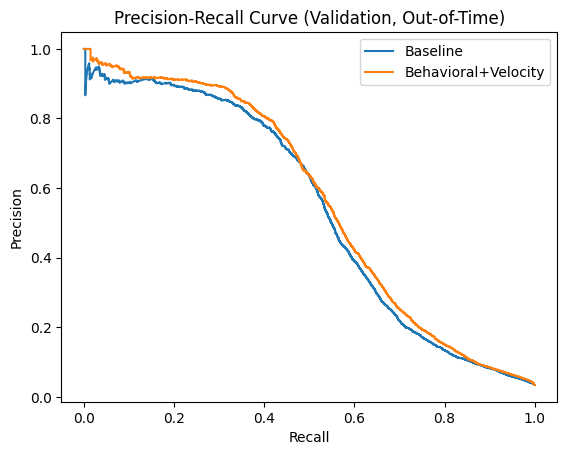

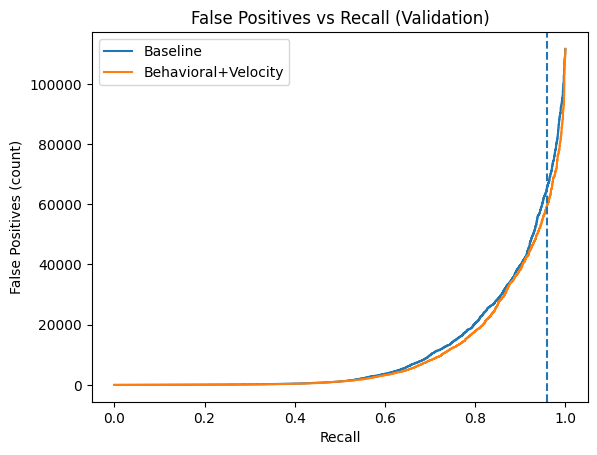

Saved: /content/drive/MyDrive/IEEE Data/outputs/run_20260119_001227/pr_curve.png
Saved: /content/drive/MyDrive/IEEE Data/outputs/run_20260119_001227/fp_vs_recall.png


In [44]:
import matplotlib.pyplot as plt

# PR curve
plt.figure()
plt.plot(r_b, p_b, label="Baseline")
plt.plot(r_n, p_n, label="Behavioral+Velocity")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation, Out-of-Time)")
plt.legend()
pr_path = os.path.join(RUN_DIR, "pr_curve.png")
plt.savefig(pr_path, dpi=150, bbox_inches="tight")
plt.show()

# FP vs Recall curve (threshold sweep)
def fp_recall_curve(y_true, y_prob):
    p, r, t = precision_recall_curve(y_true, y_prob)
    # thresholds t correspond to r[:-1], p[:-1]
    recalls = r[:-1]
    fps = []
    for thr in t:
        s = confusion_stats(y_true, y_prob, thr)
        fps.append(s["FP"])
    return recalls, np.array(fps), t

rec_b, fp_b, thr_b2 = fp_recall_curve(y_val.values, val_preds)
rec_n, fp_n, thr_n2 = fp_recall_curve(y_val.values, val_preds_new)

plt.figure()
plt.plot(rec_b, fp_b, label="Baseline")
plt.plot(rec_n, fp_n, label="Behavioral+Velocity")
plt.axvline(target_recall, linestyle="--")
plt.xlabel("Recall")
plt.ylabel("False Positives (count)")
plt.title("False Positives vs Recall (Validation)")
plt.legend()
fp_path = os.path.join(RUN_DIR, "fp_vs_recall.png")
plt.savefig(fp_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", pr_path)
print("Saved:", fp_path)


In [45]:
import joblib

# Save model artifact
model_path = os.path.join(MODEL_DIR, f"lgbm_behavioral_{run_id}.pkl")
joblib.dump(model_behavioral, model_path)

# Save thresholds/policy
policy = {
    "t_block": float(thr_new),
    "target_recall_for_t_block": target_recall,
    # if you already computed t_review earlier, include it; otherwise omit
}
policy_path = os.path.join(RUN_DIR, "policy.json")
with open(policy_path, "w") as f:
    json.dump(policy, f, indent=2)

# Save metric summary
summary_path = os.path.join(RUN_DIR, "metrics_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("Saved model:", model_path)
print("Saved policy:", policy_path)
print("Saved metrics:", summary_path)


Saved model: /content/drive/MyDrive/IEEE Data/models/lgbm_behavioral_20260119_001227.pkl
Saved policy: /content/drive/MyDrive/IEEE Data/outputs/run_20260119_001227/policy.json
Saved metrics: /content/drive/MyDrive/IEEE Data/outputs/run_20260119_001227/metrics_summary.json


In [46]:
print(
    f"Reduced false positives by {summary['fp_reduction_pct_at_target_recall']:.1f}% "
    f"while maintaining {summary['target_recall']*100:.0f}% fraud recall using "
    f"LightGBM with time-aware validation and behavioral/velocity features."
)


Reduced false positives by 9.3% while maintaining 96% fraud recall using LightGBM with time-aware validation and behavioral/velocity features.


# Google Colab is available in VS Code!
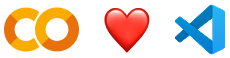

Try the new [Google Colab extension](https://marketplace.visualstudio.com/items?itemName=Google.colab) for Visual Studio Code. You can get up and running in just a few clicks:

*  In VS Code, open the ***Extensions*** view and search for 'Google Colab' to install.
*  Open the kernel selector by creating or opening any `.ipynb` notebook file in your local workspace and either running a cell or clicking the ***Select Kernel*** button in the top right.
*  Click ***Colab*** and then select your desired runtime, sign in with your Google account, and you're all set!

See more details in our [announcement blog here](https://developers.googleblog.com/google-colab-is-coming-to-vs-code).

# Access Popular LLMs via Google-Colab-AI Without an API Key

Users with Colab's paid plans have free access to most popular LLMs via google-colab-ai Python library. For more details, refer to the [getting started with google colab ai](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb).

In [47]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

The capital of France is **Paris**.


## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [48]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 19 00:16:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [49]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Intro to RAPIDS cuDF to accelerate pandas](https://nvda.ws/rapids-cudf)
- [Getting Started with cuML's accelerator mode](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [Train a CNN to classify handwritten digits on the MNIST dataset using Flax NNX API](https://colab.research.google.com/github/google/flax/blob/main/docs_nnx/mnist_tutorial.ipynb)
- [Train a Vision Transformer (ViT) for image classification with JAX](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_Vision_transformer.ipynb)
- [Text classification with a transformer language model using JAX](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_transformer_text_classification.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

A few featured examples:

- [Train a miniGPT language model with JAX AI Stack](https://docs.jaxstack.ai/en/latest/JAX_for_LLM_pretraining.html)
- [LoRA/QLoRA finetuning for LLM using Tunix](https://github.com/google/tunix/blob/main/examples/qlora_gemma.ipynb)
- [Parameter-efficient fine-tuning of Gemma with LoRA and QLoRA](https://keras.io/examples/keras_recipes/parameter_efficient_finetuning_of_gemma_with_lora_and_qlora/)
- [Loading Hugging Face Transformers Checkpoints](https://keras.io/keras_hub/guides/hugging_face_keras_integration/)
- [8-bit Integer Quantization in Keras](https://keras.io/guides/int8_quantization_in_keras/)
- [Float8 training and inference with a simple Transformer model](https://keras.io/examples/keras_recipes/float8_training_and_inference_with_transformer/)
- [Pretraining a Transformer from scratch with KerasHub](https://keras.io/keras_hub/guides/transformer_pretraining/)
- [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/)
- [Image classification from scratch using Keras 3](https://keras.io/examples/vision/image_classification_from_scratch/)
- [Image Classification with KerasHub](https://keras.io/keras_hub/guides/classification_with_keras_hub/)
